Translation of state space time series modeling from RStan to PyMC3

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
%matplotlib inline

In [3]:
# data from: https://github.com/iwanami-datascience/vol1
df = pd.read_csv('../data/data-season.txt')
print(df.shape)
df.head()

(44, 1)


,Y
0,18.073
1,23.665
2,16.410
3,14.931
4,17.106


Text(0.5, 0, 'Time [四半期]')

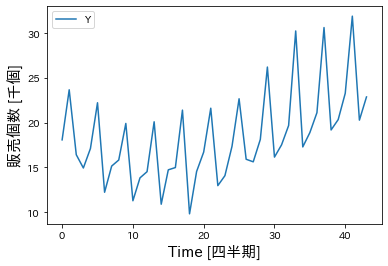

In [4]:
ax = df.plot()
ax.set_ylabel('販売個数 [千個]', fontsize=15)
ax.set_xlabel('Time [四半期]', fontsize=15)

# State Space Modeling

Observed ~ Trend + Seasonality

$$
\begin{aligned}
Y_t &= \mu_t + s_t + \varepsilon_{1, t}, \quad \varepsilon_{1, t} \sim N(0, \sigma_Y)\\
\mu_t &= \mu_{t-1} + \varepsilon_{2, t}, \quad \varepsilon_{2, t} \sim N(0, \sigma_\mu)\\
s_t &= -s_{t-1} - s_{t-2} - s_{t-3} + \varepsilon_{3, t}, \quad \varepsilon_{3, t} \sim N(0, \sigma_s)
\end{aligned}
$$

In [5]:
T = df.shape[0]

In [6]:
T

44

In [7]:
# 
mean_data = df.values.mean()
std_data = df.values.std()
mean_data, std_data

(18.455113636363635, 4.9583481634324595)

In [8]:
T = df.shape[0]
T_pred = 8
n_iter = 300
warmup = 200
n_chains=4

with pm.Model() as model:
    
    # priors of standard deviation
    
    # Trend
    ## prior distributions
    mu_mu0 = pm.Normal(name='mu_mu0', mu=mean_data, sigma=std_data)
    sigma_mu = pm.InverseGamma(name='sigma_mu', alpha=1.0, beta=1.0)
    ##\mu_{t} = \mu_{t-1} + \varepsilot_{2,t}
    mu = [0] * (T + T_pred)
    mu[0] = pm.Normal(name='mu0', mu=mu_mu0, sigma=sigma_mu)
    for i in range(1, T+T_pred):
        mu[i] = pm.Normal(name=f'mu{i}', mu=mu[i-1], sigma=sigma_mu)
    
    # Seasonality
    ## prior distributions
    mu_s0 = pm.Normal(name='mu_s0', mu=0.0, tau=1e-4)
    mu_s1 = pm.Normal(name='mu_s1', mu=0.0, tau=1e-4)
    mu_s2 = pm.Normal(name='mu_s2', mu=0.0, tau=1e-4)
    sigma_s = pm.InverseGamma(name='sigma_s', alpha=1.0, beta=1.0)
    ## s_t = -s_{t-1} - s_{t-2} - s_{t-3} + \varepsilon_{3, t}
    s = [0] * (T + T_pred)
    s[0] = pm.Normal(name='s0', mu=mu_s0, sigma=sigma_s)
    s[1] = pm.Normal(name='s1', mu=mu_s1, sigma=sigma_s)
    s[2] = pm.Normal(name='s2', mu=mu_s2, sigma=sigma_s)
    for i in range(3, T+T_pred):
        s[i] = pm.Normal(name=f's{i}', mu=-sum(s[i-3:i]), sigma=sigma_s)
    
    # Observed and Predction
    ## prior distriobution
    sigma_y = pm.InverseGamma(name='sigma_y', alpha=1.0, beta=1.0)
    ## Y_t = \mu_t + s_t + \varepsilon_{1, t}
    y = [0] * (T + T_pred)
    for i in range(0, T):
        y[i] = pm.Normal(name=f'y{i}', mu=mu[i]+s[i], sigma=sigma_y, observed=df.iloc[i])
    for i in range(T, T+T_pred):
        y[i] = pm.Normal(name=f'y{i}', mu=mu[i]+s[i], sigma=sigma_y)
        
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(n_iter, step, start=start, chains=n_chains, tune=warmup, random_seed=123)

/Users/tatamiya/Library/Caches/pypoetry/virtualenvs/state-space-0JTrBQuf-py3.8/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Only 300 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y51, y50, y49, y48, y47, y46, y45, y44, sigma_y, s51, s50, s49, s48, s47, s46, s45, s44, s43, s42, s41, s40, s39, s38, s37, s36, s35, s34, s33, s32, s31, s30, s29, s28, s27, s26, s25, s24, s23, s22, s21, s20, s19, s18, s17, s16, s15, s14, s13, s12, s11, s10, s9, s8, s7, s6, s5, s4, s3, s2, s1, s0, sigma_s, mu_s2, mu_s1, mu_s0, mu51, mu50, mu49, mu48, mu47, mu46, mu45, mu44, mu43, mu42, mu41, mu40, mu39, mu38, mu37, mu36, mu35, mu34, mu33, mu32, mu31, mu30, mu29, mu28, mu27, mu26, mu25, mu24, mu23, mu22, mu21, mu20, mu19, mu18, mu17, 

Sampling 4 chains for 200 tune and 300 draw iterations (800 + 1_200 draws total) took 64 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5419474621864883, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


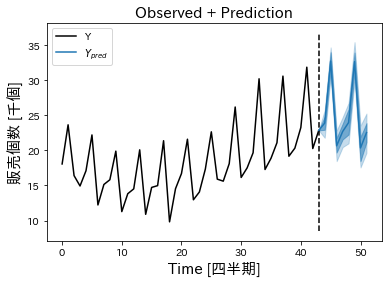

In [9]:
y_pred_samples = np.array([trace[f'y{i}'] for i in range(T, T+T_pred)])
repeat_last_value = df.values[-1].repeat(y_pred_samples.shape[1]).reshape(1,-1)
y_pred_samples = np.vstack([repeat_last_value, y_pred_samples])
y_pred = y_pred_samples.mean(axis=1)
y_lower10, y_lower25, y_upper25, y_upper10 = np.percentile(y_pred_samples, q=[10, 25, 75, 90], axis=1)
 
ax = df.plot(color='black')
ax.plot(list(range(T-1, T+T_pred)), y_pred, label='$Y_{pred}$')
ax.fill_between(list(range(T-1, T+T_pred)), y_lower10, y_upper10, alpha=0.25, color='tab:blue')
ax.fill_between(list(range(T-1, T+T_pred)), y_lower25, y_upper25, alpha=0.5, color='tab:blue')
ax.vlines(T-1, *ax.get_ylim(), linestyle='dashed', color='black')
ax.set_ylabel('販売個数 [千個]', fontsize=15)
ax.set_xlabel('Time [四半期]', fontsize=15)
ax.set_title('Observed + Prediction', fontsize=15)
ax.legend()

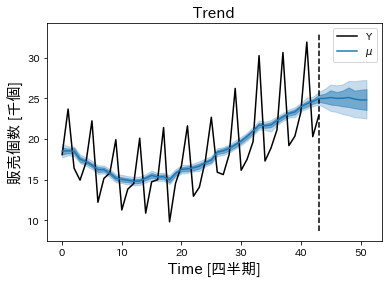

In [10]:
mu_samples = np.array([trace[f'mu{i}'] for i in range(T+T_pred)])
pred = mu_samples.mean(axis=1)
mu_lower10, mu_lower25, mu_upper25, mu_upper10 = np.percentile(mu_samples, q=[10, 25, 75, 90], axis=1)
 
ax = df.plot(color='black')
ax.plot(list(range(0, T+T_pred)), pred, label='$\mu$')
ax.fill_between(list(range(0, T+T_pred)), mu_lower10, mu_upper10, alpha=0.25, color='tab:blue')
ax.fill_between(list(range(0, T+T_pred)), mu_lower25, mu_upper25, alpha=0.5, color='tab:blue')
ax.vlines(T-1, *ax.get_ylim(), linestyle='dashed', color='black')
ax.set_ylabel('販売個数 [千個]', fontsize=15)
ax.set_xlabel('Time [四半期]', fontsize=15)
ax.set_title('Trend', fontsize=15)
ax.legend()

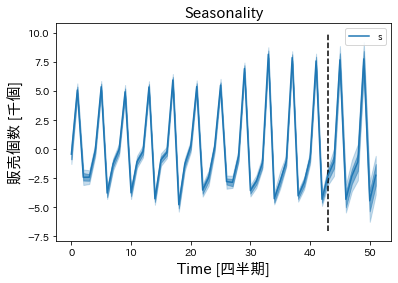

In [11]:
s_samples = np.array([trace[f's{i}'] for i in range(T+T_pred)])
pred = s_samples.mean(axis=1)
s_lower10, s_lower25, s_upper25, s_upper10 = np.percentile(s_samples, q=[10, 25, 75, 90], axis=1)
 
fig, ax = plt.subplots()
ax.plot(list(range(0, T+T_pred)), pred, label='s')
ax.fill_between(list(range(0, T+T_pred)), s_lower10, s_upper10, alpha=0.25, color='tab:blue')
ax.fill_between(list(range(0, T+T_pred)), s_lower25, s_upper25, alpha=0.5, color='tab:blue')
ax.vlines(T-1, *ax.get_ylim(), linestyle='dashed', color='black')
ax.set_ylabel('販売個数 [千個]', fontsize=15)
ax.set_xlabel('Time [四半期]', fontsize=15)
ax.set_title('Seasonality', fontsize=15)
ax.legend()

# References

- [松浦健太郎, Stan入門 ― 次世代のベイジアンモデリングツール in 岩波データサイエンス Vol.1 (岩波書店、2015)](https://www.amazon.co.jp/dp/4000298518/ref=cm_sw_r_tw_dp_x_a23UFb69ZD725)
    - source codes: https://github.com/iwanami-datascience/vol1
- [Analysis of An 𝐴𝑅(1) Model in PyMC3](https://docs.pymc.io/notebooks/AR.html)
- [Edward、PyStan、PyMC3で状態空間モデルを実装してみた](http://www.ie110704.net/2018/04/21/edward%E3%80%81pystan%E3%80%81pymc3%E3%81%A7%E7%8A%B6%E6%85%8B%E7%A9%BA%E9%96%93%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E5%AE%9F%E8%A3%85%E3%81%97%E3%81%A6%E3%81%BF%E3%81%9F/)
- [A state space model for fitting dynamics in pymc3](https://gist.github.com/npyoung/adc097f95c6148a5e31c2f388efaa697)